# HiCAT Aperture Generation Notebook Based on Hardware Calibrated Measurements
<a id="top"></a>

### Optical design
 - An entrance **[Pupil Mask](#pupil-mask)** *(P1)* with central obstruction and spiders to define an aperture shape.
 - A 37-segment **[Iris-AO](#iris-ao)** *(P2)* MEMs deformable mirror with 1.4 mm (vertex to vertex) hexagonal segments controllable in tip, tilt, and piston, conjugated to the entrance pupil to provide a pupil with complex geometry. 
 - A diffraction suppression system based on the architecture of the apodized pupil Lyot coronagraph (APLC), which includes an **[apodizer](#apodizer)** *(P3)*, a reflective focal plane mask (FPM) and a **[Lyot stop](#lyot-stop)** *(P5)*. 
 - A **[Boston deformable mirror](#dm)** *(P4)* for both wavefront control (correction of the re- sidual aberrations) and wavefront shaping (generation of a dark hole inside the PSF). This DM shows 33 actuators across the 9.9mm lateral dimension. 
 
<br>
 
 Go to [HiCAT apertures experiments](#exp).

In [1]:
#%matplotlib qt
%matplotlib inline
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [2]:
# Observables from pupil images and actuator space calibration (calculation deatils still on paper to be completed)

gamma_21_calibrated = 0.42528
gamma_42_calibrated = 1.0435
gamma_45_calibrated = 0.4542

# Old by-design version
gamma_21_design = 0.423
gamma_31_design = 1.008
gamma_41_design = 0.444
gamma_51_design = 0.979

# Plane-to-plane magnifications derived from observables: 
gamma_21 = gamma_21_calibrated
gamma_31 = 0
gamma_41 = gamma_42_calibrated * gamma_21_calibrated
gamma_51 = gamma_41 / gamma_45_calibrated

In [3]:
# Checking that the as-built testbed is actually close to the design testbed:
print(gamma_21/gamma_21_design)
print(gamma_31/gamma_31_design)
print(gamma_41/gamma_41_design)
print(gamma_51/gamma_51_design)

1.0053900709219858
0.0
0.9995037837837838
0.9980162001773033



----------
<a id="iris-ao"></a>
# P2 - Iris AO

In [4]:
# RS: doubled checked 5/22/19

In [5]:
p2_irisao_segment_size = 1.4e-3 # m (note: point to point)
p2_irisao_segment_side_length = p2_irisao_segment_size / 2
p2_irisao_segment_gap_size = 12e-6 # m
#p2_irisao_segment_gap_size = 1.212e-3/10 # note: creating a DM where gaps = 1/10 segments, tested and working using DS9
p2_irisao_inscribed_circle_size = 10 * p2_irisao_segment_side_length
p2_irisao_flat_to_flat_size = 14 * np.sqrt(3) / 2 * p2_irisao_segment_side_length
p2_irisao_circumscribed_circle_size = np.sqrt(p2_irisao_flat_to_flat_size**2 + p2_irisao_segment_side_length**2)

print(p2_irisao_inscribed_circle_size)
print(p2_irisao_circumscribed_circle_size)
print(p2_irisao_flat_to_flat_size)

0.007
0.008515867542417507
0.008487048957087498


In [6]:
irisao_gap_hexagon_fraction = p2_irisao_segment_gap_size / p2_irisao_segment_side_length
print(irisao_gap_hexagon_fraction, 0.012 / 0.7)

0.017142857142857144 0.017142857142857144


In [7]:
p2_irisao_distance_between_segments = p2_irisao_segment_side_length * np.sqrt(3)
#corrected bug, sqrt(3) replaced by 2/sqrt(3)
# tested with this value for gap size==1/10 segment size; p2_irisao_segment_gap_size = 1.212e-3/10 (measurable in DS9)
p2_irisao_segment_circumdiameter = (2 * p2_irisao_segment_side_length) - (2/np.sqrt(3)) * p2_irisao_segment_gap_size
print(p2_irisao_segment_circumdiameter)

def p2_irisao():
    segment = hexagonal_aperture(p2_irisao_segment_circumdiameter, np.pi/2)
    
    segment_positions = make_hexagonal_grid(p2_irisao_distance_between_segments, 3, False)
    
    aperture = make_segmented_aperture(segment, segment_positions)
    return aperture

0.001386143593539449


[Top of page](#top)

------------
<a id="pupil-mask"></a>
# P1 - Pupil Mask and Apodizer 

In [8]:
central_obst = False

In [9]:
p1_pupil_mask_size = 19.50e-3 # m  Note: Reducing on purpose another 50 microns for ease of alignment compared to the 19.55 Lenox laser mask
p2_pupil_mask_size = p1_pupil_mask_size * gamma_21
print(p2_pupil_mask_size)

print('Undersizing fraction of pupil wrt IRIS-AO: ',p2_pupil_mask_size / p2_irisao_circumscribed_circle_size)


0.00829296
Undersizing fraction of pupil wrt IRIS-AO:  0.9738244469741686


In [10]:
# Central segment
p1_pupil_mask_central_segment_size = 3.600e-3 # m
p2_pupil_mask_central_segment_size = p1_pupil_mask_central_segment_size * gamma_21
pupil_mask_central_segment_oversize_factor = p2_pupil_mask_central_segment_size / p2_irisao_segment_size
print(pupil_mask_central_segment_oversize_factor)

1.0935771428571428


In [11]:
# Spiders
p1_pupil_mask_spider_thickness = 0.200e-3 # m

In [12]:
pupil_mask_undersize_contour = p2_pupil_mask_size / p2_irisao_circumscribed_circle_size
print(pupil_mask_undersize_contour)

0.9738244469741686


In [13]:
# Output
print('Pupil mask side-to-side contour length in P1: %d um' % (p1_pupil_mask_size * 1e6))
print('Pupil mask central segment side length in P1: %d um' % (p1_pupil_mask_central_segment_size * 1e6))
print('Pupil mask spider thickness in P1: %d um' % (p1_pupil_mask_spider_thickness * 1e6))

Pupil mask side-to-side contour length in P1: 19500 um
Pupil mask central segment side length in P1: 3600 um
Pupil mask spider thickness in P1: 200 um


In [14]:
def p1_pupil_mask(central_obst=False):
    segment = hexagonal_aperture(p1_pupil_mask_size / 7 / np.sqrt(3) * 2, np.pi / 2)
    distance_between_segments = p1_pupil_mask_size / 7
    segment_positions = make_hexagonal_grid(distance_between_segments, 3)
    contour = make_segmented_aperture(segment, segment_positions)
    
    if central_obst:
        central_segment = hexagonal_aperture(p1_pupil_mask_central_segment_size, np.pi / 2)
    
        spider1 = make_spider_infinite([0,0], 60, p1_pupil_mask_spider_thickness)
        spider2 = make_spider_infinite([0,0], 120, p1_pupil_mask_spider_thickness)
        spider3 = make_spider_infinite([0,0], -60, p1_pupil_mask_spider_thickness)
        spider4 = make_spider_infinite([0,0], -120, p1_pupil_mask_spider_thickness)
    
        def aper(grid):
            return (contour(grid) - central_segment(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    def aper(grid):
            return contour(grid)
    return aper

[Top of page](#top)

------------
<a id="dm"></a>

# P4 - Boston DM

In [15]:
p4_boston_dm_size = 9.9e-3 # m
num_actuators = 34
actuator_pitch = p4_boston_dm_size / (num_actuators-1)

In [16]:
p4_apodizer_size = p1_pupil_mask_size * gamma_41
p4_irisao_circumscribed_circle_size = p2_irisao_circumscribed_circle_size * gamma_41 / gamma_21
p4_irisao_flat_to_flat_size = p2_irisao_flat_to_flat_size * gamma_41 / gamma_21

In [17]:
boston_dm_apodizer_undersize_ratio = p4_apodizer_size / p4_boston_dm_size  #shortcutting circumscribed for flat-flat
boston_dm_irisao_undersize_ratio_y =  p4_irisao_flat_to_flat_size / p4_boston_dm_size

print(boston_dm_apodizer_undersize_ratio)
print(boston_dm_irisao_undersize_ratio_y)

0.8741114909090909
0.8945692511839197


In [18]:
num_actuators_used_apodizer = boston_dm_apodizer_undersize_ratio * (num_actuators-1)
num_actuators_used_irisao = boston_dm_irisao_undersize_ratio_y * (num_actuators-1)

In [19]:
print('Actuator pitch: %d um' % (actuator_pitch * 1e6))
print('Number of used actuator spaces inside apodizer: %0.2f' % (num_actuators_used_apodizer))
print('Number of used actuator spaces inside iris-ao: %0.2f' % (num_actuators_used_irisao))
print('Compare with the actuator spaces in the  ')

Actuator pitch: 300 um
Number of used actuator spaces inside apodizer: 28.85
Number of used actuator spaces inside iris-ao: 29.52
Compare with the actuator spaces in the  


In [20]:
def p4_boston_dm():
    return circular_aperture(p4_boston_dm_size)

[Top of page](#top)

----------
<a id="lyot-stop"></a>

# P5 - Lyot stop

In [21]:
LS_central_obst = False

In [22]:
p5_lyot_stop_size = 15.0e-3 # m
p5_irisao_inscribed_circle_size = p2_irisao_inscribed_circle_size * gamma_51 / gamma_21
lyot_stop_mask_undersize_contour_wrt_inscribed_circle = p5_lyot_stop_size / p5_irisao_inscribed_circle_size

p5_irisao_flat_to_flat_size = p2_irisao_flat_to_flat_size * gamma_51 / gamma_21
p5_irisao_circumscribed_circle_size = p2_irisao_circumscribed_circle_size * gamma_51 / gamma_21

print('LS size:', p5_lyot_stop_size*1000, 'mm')
print('iris-ao inscribed circle size at LS plane:', p5_irisao_inscribed_circle_size*1000, 'mm')
print('lateral LS alignment margin wrt to inscribed circle on both sides:', 0.5*(p5_irisao_inscribed_circle_size-p5_lyot_stop_size)*1000, 'mm')

LS size: 15.0 mm
iris-ao inscribed circle size at LS plane: 16.082122413033908 mm
lateral LS alignment margin wrt to inscribed circle on both sides: 0.5410612065169536 mm


In [23]:
def p5_lyot_stop():
    outer_diameter = circular_aperture(p5_lyot_stop_size)
    
    
    if LS_central_obst:
        # Central segment
        p5_lyot_stop_mask_central_segment_size = 6.800e-3 # m
        p5_apodizer_mask_central_segment_size = p3_apodizer_mask_central_segment_size * gamma_51 / gamma_31
        print(p5_apodizer_mask_central_segment_size)
        p5_irisao_segment_size = p2_irisao_segment_size * gamma_51 / gamma_21
        lyot_stop_mask_central_segment_oversize_factor_wrt_apodizer_mask = p5_lyot_stop_mask_central_segment_size / p5_apodizer_mask_central_segment_size
        print(lyot_stop_mask_central_segment_oversize_factor_wrt_apodizer_mask)

        # Spiders
        p5_lyot_stop_mask_spiders_thickness = 0.700e-3 # m
        lyot_stop_mask_spiders_thickness_ratio = p5_lyot_stop_mask_spiders_thickness / p5_irisao_circumscribed_circle_size
        print(lyot_stop_mask_spiders_thickness_ratio)
        central_obscuration = circular_aperture(p5_lyot_stop_mask_central_segment_size)

        spider1 = make_spider_infinite([0,0], 60, p5_lyot_stop_mask_spiders_thickness)
        spider2 = make_spider_infinite([0,0], 120, p5_lyot_stop_mask_spiders_thickness)
        spider3 = make_spider_infinite([0,0], -60, p5_lyot_stop_mask_spiders_thickness)
        spider4 = make_spider_infinite([0,0], -120, p5_lyot_stop_mask_spiders_thickness)

        def aper(grid):
            return (outer_diameter(grid) - central_obscuration(grid)) * spider1(grid) * spider2(grid) * spider3(grid) * spider4(grid)
    def aper(grid):
            return outer_diameter(grid)
    return aper

## Pixel calculation for the apodzier and DM sizes and pixels

In [24]:
print(p4_apodizer_size)
print(p4_boston_dm_size)
print(p4_apodizer_size/p4_boston_dm_size)

0.008653703760000001
0.0099
0.8741114909090909


we can keep the 486 value and the number of pixels in the DM is slighlty different (from 554.94) but not a problme because still plenty of room for padding without having to change the size of the FFTs.  Since we have used 486 pix for the apodizer in the past, we can keep that.

In [25]:
486 / (p4_apodizer_size/p4_boston_dm_size)

555.9931485336632

pixel size is very close to 10 microns:

In [26]:
19.50 / (486*4)

0.010030864197530864

A possibly better number is 488, which gives us more room for multi-scale optimization starting at smaller sizes
This translates to 1952 pixles with 10 microns pixels, and still provides 30 microns of additional alignment tolerancing compared to the current mask we have. 


[Top of page](#top)

------------------------
# Plots

In [27]:
# Here the reference is plane P2 - but the largest size of the array is for the Boston DM (largest optic)
nPixelBostonDM = 556 
g = make_pupil_grid(nPixelBostonDM, p4_boston_dm_size / gamma_41 * gamma_21)
supersampling = 1

irisao = evaluate_supersampled(p2_irisao(), g, supersampling)
pupil_mask = evaluate_supersampled(p1_pupil_mask(), g.scaled(1 / gamma_21), supersampling)
#apodizer = evaluate_supersampled(p3_apodizer(), g.scaled(gamma_31 / gamma_21), supersampling)
boston_dm = evaluate_supersampled(p4_boston_dm(), g.scaled(gamma_41 / gamma_21), supersampling)
lyot_stop = evaluate_supersampled(p5_lyot_stop(), g.scaled(gamma_51 / gamma_21), supersampling)

# debugging purposes: 
#write_fits(irisao, 'masks/irisao.fits')
#write_fits(apodizer, 'masks/apodizer.fits')

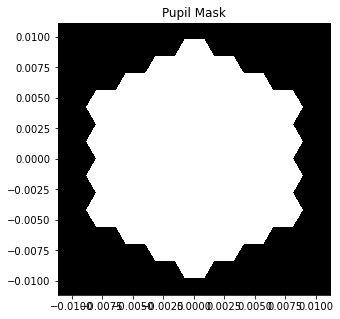

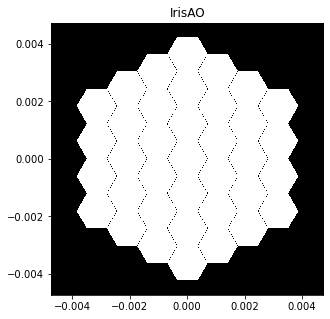

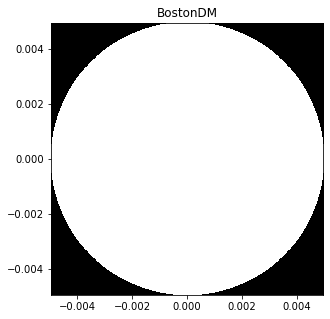

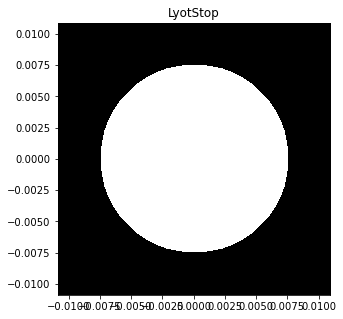

In [28]:
masks = [pupil_mask, irisao, boston_dm, lyot_stop]
labels = ['Pupil Mask', 'IrisAO', 'BostonDM', 'LyotStop']

for mask, label in zip(masks, labels):
    plt.figure(figsize = (5,5))
    plt.title(label)
    imshow_field(mask, cmap='gray')
    plt.show()

In [29]:
# for i, (mask_a, label_a) in enumerate(zip(masks, labels)):
#    for j, (mask_b, label_b) in enumerate(zip(masks, labels)):
#        if j <= i:
#            continue
       
#        plt.figure()
#        plt.title(label_a + ' - ' + label_b)
#        imshow_field(mask_a - mask_b, cmap='gray', vmin=-1, vmax=1)
#        plt.show()

In [30]:
nPixApodizer = 488;
magnification_tolerance = 0.000 # not investigated yet, in case we want to add robustness to magnification later
nlyotstops = 1 # for the magnification robustness 
gray_apod = False # because the apodizer defines the pupil (and oversizes all the structures) we don't want it gray
for gray in [True]:
    for num_pix in [nPixApodizer]:
        grid = make_uniform_grid(num_pix, [p1_pupil_mask_size, p1_pupil_mask_size])

        own_apod = evaluate_supersampled(p1_pupil_mask(), grid, 4 if gray_apod else 1)
        write_fits(own_apod, '../../masks/HiCAT/hicat_apodizer_mask_%d_%s.fits' % (num_pix, 'gy' if gray_apod else 'bw'))

        for mag_i, mag in enumerate(np.linspace(-magnification_tolerance/2, magnification_tolerance/2, nlyotstops)+1):
            own_lyot = evaluate_supersampled(p5_lyot_stop(), grid.scaled(mag * gamma_51), 4 if gray else 1)
            write_fits(own_lyot, '../../masks/HiCAT/hicat_lyot_mask_%d_%s_%d.fits' % (num_pix, 'gy' if gray else 'bw', mag_i))

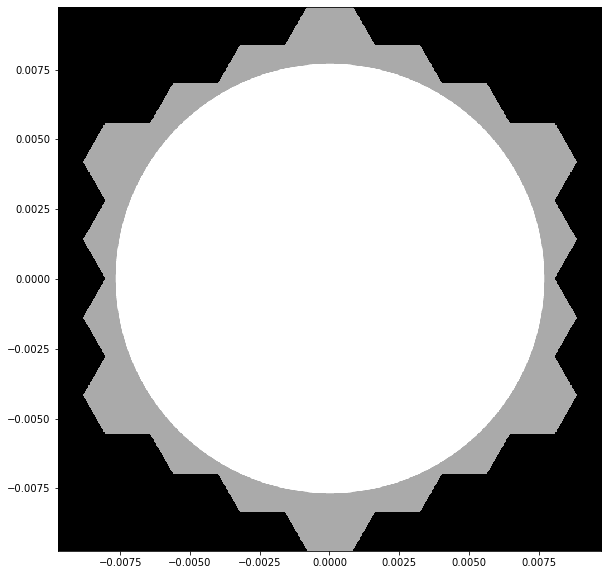

In [31]:
plt.figure(figsize = (10,10))
imshow_field(own_apod+ 0.5*own_lyot, cmap='gray')
plt.show()

------------------------
[Top of page](#top)